In [153]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [154]:
def list_directory_tree_with_os_walk(starting_directory):
    for root, directories, files in os.walk(starting_directory):
        print(f"Directory: {root}")
        for file in files:
            print(f"  File: {file}")

list_directory_tree_with_os_walk('.')

Directory: .
  File: make_org_datasets.ipynb
  File: data_cleaning.ipynb
  File: test.csv
  File: models.ipynb
  File: feature_engineering.ipynb
  File: models_each_location.ipynb
  File: sample_submission.csv
Directory: ./make_org_datasets
  File: test.csv
  File: training_and_validation.csv
Directory: ./.venv
  File: pyvenv.cfg
  File: .gitignore
Directory: ./.venv/bin
  File: pip3.9
  File: pyftsubset
  File: jupyter-run
  File: Activate.ps1
  File: python3
  File: ttx
  File: easy_install
  File: python
  File: pip3
  File: ipython
  File: activate.fish
  File: easy_install-3.9
  File: fonttools
  File: python3.9
  File: f2py
  File: ipython3
  File: pip
  File: pip3.11
  File: jupyter-troubleshoot
  File: pygmentize
  File: jupyter-migrate
  File: tabulate
  File: activate
  File: normalizer
  File: jupyter-kernelspec
  File: jupyter-kernel
  File: jupyter
  File: pyftmerge
  File: activate.csh
Directory: ./.venv/include
Directory: ./.venv/lib
Directory: ./.venv/lib/python3.9
Dire

In [155]:
train_a = pd.read_parquet('data/A/train_targets.parquet')
train_b = pd.read_parquet('data/B/train_targets.parquet')
train_c = pd.read_parquet('data/C/train_targets.parquet')

In [156]:
X_train_estimated_a = pd.read_parquet('data/A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('data/B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('data/C/X_train_estimated.parquet')

In [157]:
X_train_observed_a = pd.read_parquet('data/A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('data/B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('data/C/X_train_observed.parquet')

In [158]:
X_test_estimated_a = pd.read_parquet('data/A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('data/B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('data/C/X_test_estimated.parquet')

#### Creating training/validation/test sets for each location

##### Location A

In [159]:
df = X_test_estimated_a
# Assuming 'date_forecast' is a datetime column
df['hourly_timestamp'] = df['date_forecast'].dt.floor('H')
# Group by 'hourly_timestamp' and calculate the mean for each group
df = df.groupby('hourly_timestamp').mean().reset_index()
# Drop the 'hourly_timestamp' column if you don't need it in the final DataFrame
df.drop(columns=['hourly_timestamp'], inplace=True)
df['date_forecast'] = df['date_forecast'].dt.floor('H')

test_A = df

In [160]:
df = X_train_observed_a
# Assuming 'date_forecast' is a datetime column
df['hourly_timestamp'] = df['date_forecast'].dt.floor('H')
# Group by 'hourly_timestamp' and calculate the mean for each group
df = df.groupby('hourly_timestamp').mean().reset_index()
# Drop the 'hourly_timestamp' column if you don't need it in the final DataFrame
df.drop(columns=['hourly_timestamp'], inplace=True)
df['date_forecast'] = df['date_forecast'].dt.floor('H')

training_A = df

In [161]:
df = X_train_estimated_a
# Assuming 'date_forecast' is a datetime column
df['hourly_timestamp'] = df['date_forecast'].dt.floor('H')
# Group by 'hourly_timestamp' and calculate the mean for each group
df = df.groupby('hourly_timestamp').mean().reset_index()
# Drop the 'hourly_timestamp' column if you don't need it in the final DataFrame
df.drop(columns=['hourly_timestamp'], inplace=True)
df['date_forecast'] = df['date_forecast'].dt.floor('H')

validation_A = df

In [162]:
# For 'training_A'
training_A = training_A.merge(train_a[['time', 'pv_measurement']], how='inner', left_on='date_forecast', right_on='time')
training_A.drop('time', axis=1, inplace=True)

# Remove rows where 'pv_measurement' is NaN
training_A.dropna(subset=['pv_measurement'], inplace=True)

# For 'validation_A'
validation_A = validation_A.merge(train_a[['time', 'pv_measurement']], how='inner', left_on='date_forecast', right_on='time')
validation_A.drop('time', axis=1, inplace=True)

# Remove rows where 'pv_measurement' is NaN
validation_A.dropna(subset=['pv_measurement'], inplace=True)

In [163]:
training_A = training_A[training_A['pv_measurement'] >= 0]
validation_A = validation_A[validation_A['pv_measurement'] >= 0]

In [164]:
training_A

,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,pv_measurement
0,2019-06-02 22:00:00,7.700,1.22825,1728.949951,0.000000,0.00,1728.949951,0.0,280.299988,0.000,0.000000,0.00,0.000000,99.074997,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1006.299988,0.0,0.0,993.750000,999.775024,0.0,0.000,71.674995,1005.799988,NaN,0.0,0.0,0.0,0.175,348.036743,-3.774250,0.0,286.225006,100.000000,40386.476562,3.600,-3.575,-0.500,0.0,0.00
1,2019-06-02 23:00:00,7.700,1.22350,1689.824951,0.000000,0.00,1689.824951,0.0,280.299988,0.000,0.000000,0.00,0.000000,99.750000,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1005.200012,0.0,0.0,992.674988,998.650024,0.0,0.025,68.000000,1004.650024,NaN,0.0,0.0,0.0,0.200,91.980751,-4.357250,0.0,286.899994,100.000000,33770.648438,3.350,-3.350,0.275,0.0,0.00
2,2019-06-03 00:00:00,7.875,1.21975,1563.224976,0.000000,0.00,1563.224976,0.0,280.649994,0.000,0.000000,0.00,0.000000,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1004.525024,0.0,0.0,992.000000,997.974976,0.0,0.100,67.949997,1003.950012,NaN,0.0,0.0,0.0,0.400,14.934750,-3.309500,0.0,286.950012,100.000000,13595.500000,3.050,-2.950,0.750,0.0,0.00
3,2019-06-03 01:00:00,8.425,1.21800,1283.425049,208.649994,0.75,1283.425049,0.0,281.674988,0.300,526.775024,0.00,0.000000,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.25,1.0,1004.025024,0.0,0.0,991.500000,997.449951,0.0,0.125,73.875000,1003.449951,NaN,0.0,0.0,0.0,0.550,28.630251,-0.822500,0.0,286.750000,100.000000,2321.850098,2.725,-2.600,0.875,0.0,0.00
4,2019-06-03 02:00:00,8.950,1.21800,1003.500000,32468.150391,23.10,1003.500000,0.0,282.500000,11.975,22068.949219,0.15,282.975006,84.875000,6.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,1003.099976,0.0,0.0,990.550049,996.500000,0.0,0.100,79.925003,1002.500000,NaN,0.0,0.0,0.0,0.250,41.997501,3.051250,0.0,286.450012,99.224998,11634.799805,2.550,-2.350,0.925,0.0,19.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29662,2022-10-20 20:00:00,5.800,1.28050,1291.500000,0.000000,0.00,1192.550049,0.0,275.799988,0.000,0.000000,0.00,0.000000,38.125000,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1019.500000,0.0,0.0,1006.599976,1012.849976,0.0,0.000,78.649994,1019.125000,NaN,0.0,0.0,0.0,0.000,313.254761,-29.704250,0.0,278.250000,47.050003,40105.472656,1.925,0.475,1.850,0.0,0.00
29663,2022-10-20 21:00:00,5.575,1.28400,NaN,0.000000,0.00,686.900024,0.0,275.200012,0.000,0.000000,0.00,0.000000,16.275000,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1019.250000,0.0,0.0,1006.375000,1012.625000,0.0,0.000,79.125000,1018.900024,NaN,0.0,0.0,0.0,0.000,329.987762,-33.860748,0.0,277.850006,19.500000,39001.398438,1.675,0.250,1.675,0.0,0.00
29664,2022-10-20 22:00:00,5.350,1.28700,NaN,0.000000,0.00,149.500000,0.0,274.600006,0.000,0.000000,0.00,0.000000,9.700000,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1018.974976,0.0,0.0,1006.099976,1012.349976,0.0,0.000,79.974998,1018.650024,NaN,0.0,0.0,0.0,0.000,347.845490,-36.270000,0.0,277.475006,9.700000,35336.726562,1.400,0.050,1.400,0.0,0.00
29665,2022-10-20 23:00:00,5.200,1.29050,NaN,0.000000,0.00,NaN,0.0,274.174988,0.000,0.000000,0.00,0.000000,4.525000,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1018.650024,0.0,0.0,1005.775024,1012.049988,0.0,0.000,81.199997,1018

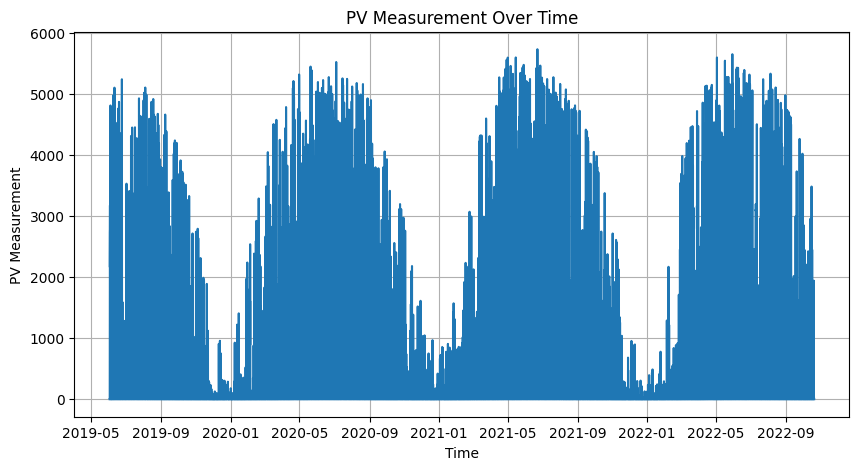

In [165]:
plt.figure(figsize=(10, 5))
plt.plot(training_A['date_forecast'], training_A['pv_measurement'])
plt.xlabel('Time')
plt.ylabel('PV Measurement')
plt.title('PV Measurement Over Time')
plt.grid(True)
plt.show()

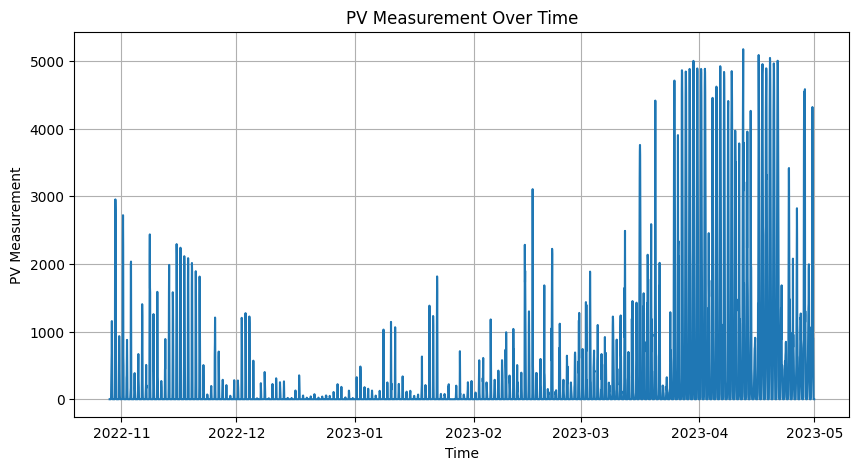

In [166]:
plt.figure(figsize=(10, 5))
plt.plot(validation_A['date_forecast'], validation_A['pv_measurement'])
plt.xlabel('Time')
plt.ylabel('PV Measurement')
plt.title('PV Measurement Over Time')
plt.grid(True)
plt.show()

##### Location B

In [167]:
df = X_test_estimated_b
# Assuming 'date_forecast' is a datetime column
df['hourly_timestamp'] = df['date_forecast'].dt.floor('H')
# Group by 'hourly_timestamp' and calculate the mean for each group
df = df.groupby('hourly_timestamp').mean().reset_index()
# Drop the 'hourly_timestamp' column if you don't need it in the final DataFrame
df.drop(columns=['hourly_timestamp'], inplace=True)
df['date_forecast'] = df['date_forecast'].dt.floor('H')

test_B = df

In [168]:
df = X_train_observed_b
# Assuming 'date_forecast' is a datetime column
df['hourly_timestamp'] = df['date_forecast'].dt.floor('H')
# Group by 'hourly_timestamp' and calculate the mean for each group
df = df.groupby('hourly_timestamp').mean().reset_index()
# Drop the 'hourly_timestamp' column if you don't need it in the final DataFrame
df.drop(columns=['hourly_timestamp'], inplace=True)
df['date_forecast'] = df['date_forecast'].dt.floor('H')

training_B = df

In [169]:
df = X_train_estimated_b
# Assuming 'date_forecast' is a datetime column
df['hourly_timestamp'] = df['date_forecast'].dt.floor('H')
# Group by 'hourly_timestamp' and calculate the mean for each group
df = df.groupby('hourly_timestamp').mean().reset_index()
# Drop the 'hourly_timestamp' column if you don't need it in the final DataFrame
df.drop(columns=['hourly_timestamp'], inplace=True)
df['date_forecast'] = df['date_forecast'].dt.floor('H')

validation_B = df

In [170]:
# For 'training_B'
training_B = training_B.merge(train_b[['time', 'pv_measurement']], how='inner', left_on='date_forecast', right_on='time')
training_B.drop('time', axis=1, inplace=True)

# Remove rows where 'pv_measurement' is NaN
training_B.dropna(subset=['pv_measurement'], inplace=True)

# For 'validation_B'
validation_B = validation_B.merge(train_b[['time', 'pv_measurement']], how='inner', left_on='date_forecast', right_on='time')
validation_B.drop('time', axis=1, inplace=True)

# Remove rows where 'pv_measurement' is NaN
validation_B.dropna(subset=['pv_measurement'], inplace=True)

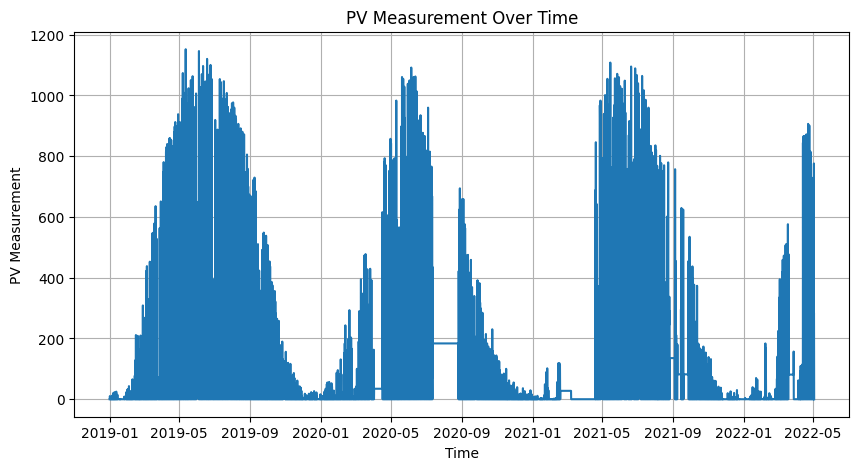

In [171]:
plt.figure(figsize=(10, 5))
plt.plot(training_B['date_forecast'], training_B['pv_measurement'])
plt.xlabel('Time')
plt.ylabel('PV Measurement')
plt.title('PV Measurement Over Time')
plt.grid(True)
plt.show()

In [172]:
training_B['date_forecast'] = pd.to_datetime(training_B['date_forecast'])
training_B_mod = training_B[(training_B['date_forecast'] < pd.to_datetime('2020-02-20 00:00:00')) | (training_B['date_forecast'] >= pd.to_datetime('2020-03-10 00:00:00'))]

training_B_mod = training_B_mod[(training_B_mod['date_forecast'] < pd.to_datetime('2021-01-01 00:00:00')) | (training_B_mod['date_forecast'] >= pd.to_datetime('2021-04-01 00:00:00'))]

training_B_mod = training_B_mod[(training_B_mod['date_forecast'] < pd.to_datetime('2021-08-18 00:00:00')) | (training_B_mod['date_forecast'] >= pd.to_datetime('2021-10-01 00:00:00'))]

training_B_mod = training_B_mod[(training_B_mod['date_forecast'] < pd.to_datetime('2022-02-02 00:00:00')) | (training_B_mod['date_forecast'] >= pd.to_datetime('2022-03-01 00:00:00'))]

training_B_mod = training_B_mod[(training_B_mod['date_forecast'] < pd.to_datetime('2022-03-15 00:00:00')) | (training_B_mod['date_forecast'] >= pd.to_datetime('2022-04-15 00:00:00'))]

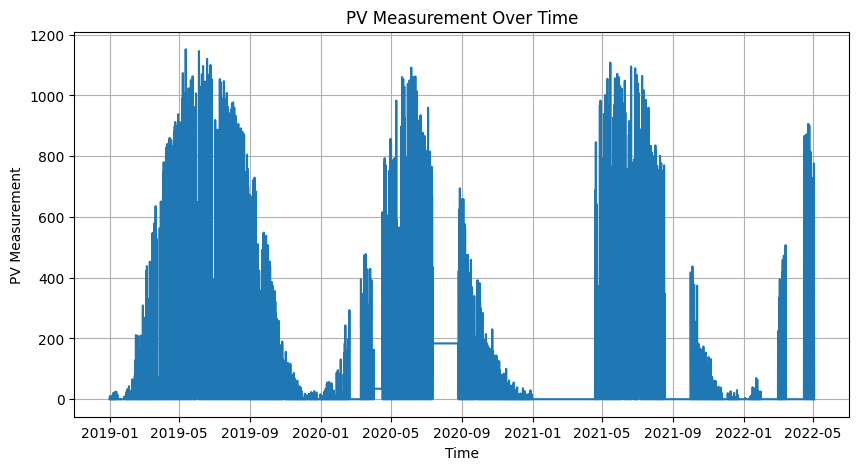

In [173]:
plt.figure(figsize=(10, 5))
plt.plot(training_B_mod['date_forecast'], training_B_mod['pv_measurement'])
plt.xlabel('Time')
plt.ylabel('PV Measurement')
plt.title('PV Measurement Over Time')
plt.grid(True)
plt.show()

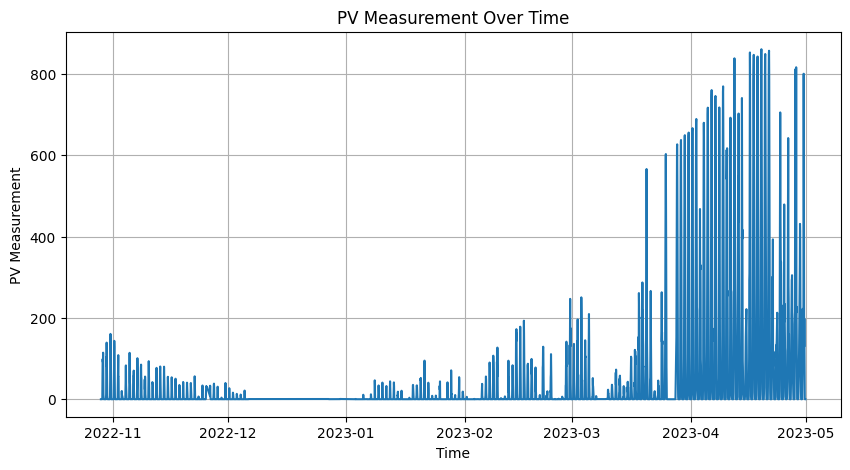

In [174]:
plt.figure(figsize=(10, 5))
plt.plot(validation_B['date_forecast'], validation_B['pv_measurement'])
plt.xlabel('Time')
plt.ylabel('PV Measurement')
plt.title('PV Measurement Over Time')
plt.grid(True)
plt.show()

##### Location C

In [175]:
df = X_test_estimated_c
# Assuming 'date_forecast' is a datetime column
df['hourly_timestamp'] = df['date_forecast'].dt.floor('H')
# Group by 'hourly_timestamp' and calculate the mean for each group
df = df.groupby('hourly_timestamp').mean().reset_index()
# Drop the 'hourly_timestamp' column if you don't need it in the final DataFrame
df.drop(columns=['hourly_timestamp'], inplace=True)
df['date_forecast'] = df['date_forecast'].dt.floor('H')

test_C = df

In [176]:
df = X_train_observed_c
# Assuming 'date_forecast' is a datetime column
df['hourly_timestamp'] = df['date_forecast'].dt.floor('H')
# Group by 'hourly_timestamp' and calculate the mean for each group
df = df.groupby('hourly_timestamp').mean().reset_index()
# Drop the 'hourly_timestamp' column if you don't need it in the final DataFrame
df.drop(columns=['hourly_timestamp'], inplace=True)
df['date_forecast'] = df['date_forecast'].dt.floor('H')

training_C = df

In [177]:
df = X_train_estimated_c
# Assuming 'date_forecast' is a datetime column
df['hourly_timestamp'] = df['date_forecast'].dt.floor('H')
# Group by 'hourly_timestamp' and calculate the mean for each group
df = df.groupby('hourly_timestamp').mean().reset_index()
# Drop the 'hourly_timestamp' column if you don't need it in the final DataFrame
df.drop(columns=['hourly_timestamp'], inplace=True)
df['date_forecast'] = df['date_forecast'].dt.floor('H')

validation_C = df

In [178]:
# For 'training_C'
training_C = training_C.merge(train_c[['time', 'pv_measurement']], how='inner', left_on='date_forecast', right_on='time')
training_C.drop('time', axis=1, inplace=True)

# Remove rows where 'pv_measurement' is NaN
training_C.dropna(subset=['pv_measurement'], inplace=True)

# For 'validation_C'
validation_C = validation_C.merge(train_c[['time', 'pv_measurement']], how='inner', left_on='date_forecast', right_on='time')
validation_C.drop('time', axis=1, inplace=True)

# Remove rows where 'pv_measurement' is NaN
validation_C.dropna(subset=['pv_measurement'], inplace=True)

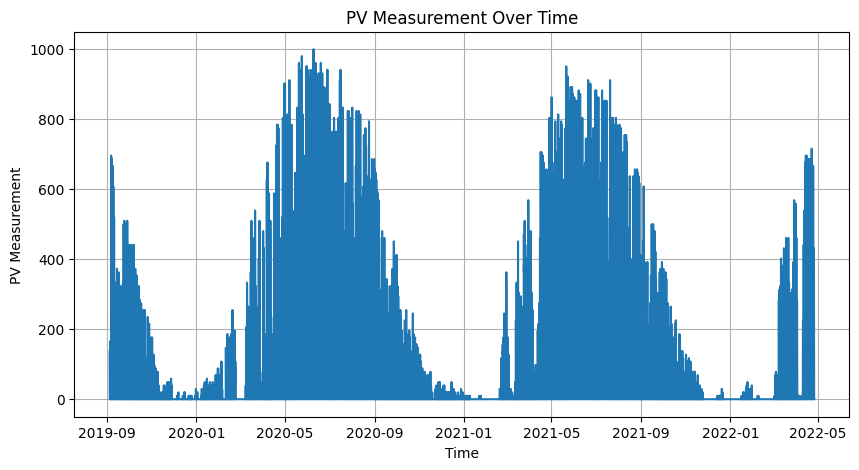

In [179]:
plt.figure(figsize=(10, 5))
plt.plot(training_C['date_forecast'], training_C['pv_measurement'])
plt.xlabel('Time')
plt.ylabel('PV Measurement')
plt.title('PV Measurement Over Time')
plt.grid(True)
plt.show()

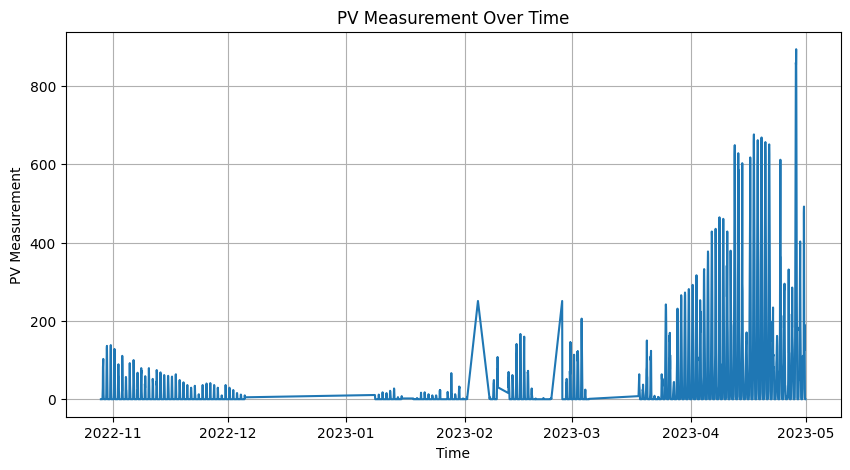

In [180]:
plt.figure(figsize=(10, 5))
plt.plot(validation_C['date_forecast'], validation_C['pv_measurement'])
plt.xlabel('Time')
plt.ylabel('PV Measurement')
plt.title('PV Measurement Over Time')
plt.grid(True)
plt.show()

In [181]:
validation_C['date_forecast'] = pd.to_datetime(validation_C['date_forecast'])
validation_C_mod = validation_C[(validation_C['date_forecast'] < pd.to_datetime('2023-02-01 00:00:00')) | (validation_C['date_forecast'] >= pd.to_datetime('2023-02-10 00:00:00'))]
validation_C_mod = validation_C_mod[(validation_C_mod['date_forecast'] < pd.to_datetime('2023-02-18 00:00:00')) | (validation_C_mod['date_forecast'] >= pd.to_datetime('2023-02-28 00:00:00'))]

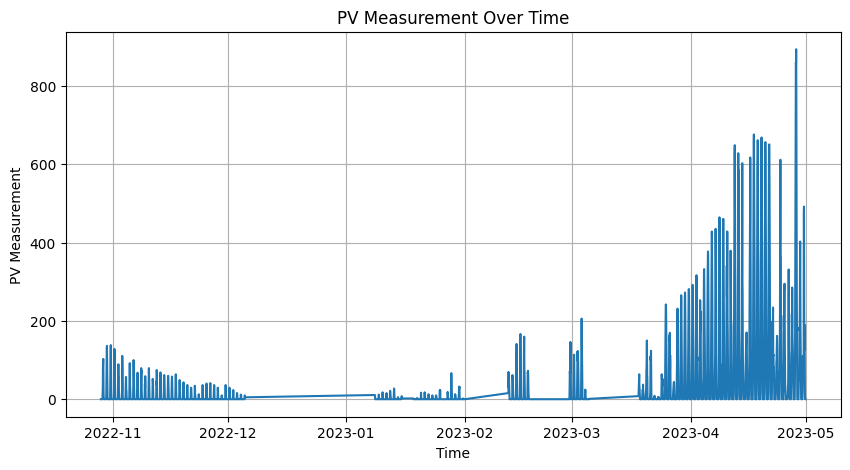

In [182]:
plt.figure(figsize=(10, 5))
plt.plot(validation_C_mod['date_forecast'], validation_C_mod['pv_measurement'])
plt.xlabel('Time')
plt.ylabel('PV Measurement')
plt.title('PV Measurement Over Time')
plt.grid(True)
plt.show()

In [183]:
training_A

,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,pv_measurement
0,2019-06-02 22:00:00,7.700,1.22825,1728.949951,0.000000,0.00,1728.949951,0.0,280.299988,0.000,0.000000,0.00,0.000000,99.074997,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1006.299988,0.0,0.0,993.750000,999.775024,0.0,0.000,71.674995,1005.799988,NaN,0.0,0.0,0.0,0.175,348.036743,-3.774250,0.0,286.225006,100.000000,40386.476562,3.600,-3.575,-0.500,0.0,0.00
1,2019-06-02 23:00:00,7.700,1.22350,1689.824951,0.000000,0.00,1689.824951,0.0,280.299988,0.000,0.000000,0.00,0.000000,99.750000,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1005.200012,0.0,0.0,992.674988,998.650024,0.0,0.025,68.000000,1004.650024,NaN,0.0,0.0,0.0,0.200,91.980751,-4.357250,0.0,286.899994,100.000000,33770.648438,3.350,-3.350,0.275,0.0,0.00
2,2019-06-03 00:00:00,7.875,1.21975,1563.224976,0.000000,0.00,1563.224976,0.0,280.649994,0.000,0.000000,0.00,0.000000,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1004.525024,0.0,0.0,992.000000,997.974976,0.0,0.100,67.949997,1003.950012,NaN,0.0,0.0,0.0,0.400,14.934750,-3.309500,0.0,286.950012,100.000000,13595.500000,3.050,-2.950,0.750,0.0,0.00
3,2019-06-03 01:00:00,8.425,1.21800,1283.425049,208.649994,0.75,1283.425049,0.0,281.674988,0.300,526.775024,0.00,0.000000,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.25,1.0,1004.025024,0.0,0.0,991.500000,997.449951,0.0,0.125,73.875000,1003.449951,NaN,0.0,0.0,0.0,0.550,28.630251,-0.822500,0.0,286.750000,100.000000,2321.850098,2.725,-2.600,0.875,0.0,0.00
4,2019-06-03 02:00:00,8.950,1.21800,1003.500000,32468.150391,23.10,1003.500000,0.0,282.500000,11.975,22068.949219,0.15,282.975006,84.875000,6.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,1003.099976,0.0,0.0,990.550049,996.500000,0.0,0.100,79.925003,1002.500000,NaN,0.0,0.0,0.0,0.250,41.997501,3.051250,0.0,286.450012,99.224998,11634.799805,2.550,-2.350,0.925,0.0,19.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29662,2022-10-20 20:00:00,5.800,1.28050,1291.500000,0.000000,0.00,1192.550049,0.0,275.799988,0.000,0.000000,0.00,0.000000,38.125000,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1019.500000,0.0,0.0,1006.599976,1012.849976,0.0,0.000,78.649994,1019.125000,NaN,0.0,0.0,0.0,0.000,313.254761,-29.704250,0.0,278.250000,47.050003,40105.472656,1.925,0.475,1.850,0.0,0.00
29663,2022-10-20 21:00:00,5.575,1.28400,NaN,0.000000,0.00,686.900024,0.0,275.200012,0.000,0.000000,0.00,0.000000,16.275000,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1019.250000,0.0,0.0,1006.375000,1012.625000,0.0,0.000,79.125000,1018.900024,NaN,0.0,0.0,0.0,0.000,329.987762,-33.860748,0.0,277.850006,19.500000,39001.398438,1.675,0.250,1.675,0.0,0.00
29664,2022-10-20 22:00:00,5.350,1.28700,NaN,0.000000,0.00,149.500000,0.0,274.600006,0.000,0.000000,0.00,0.000000,9.700000,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1018.974976,0.0,0.0,1006.099976,1012.349976,0.0,0.000,79.974998,1018.650024,NaN,0.0,0.0,0.0,0.000,347.845490,-36.270000,0.0,277.475006,9.700000,35336.726562,1.400,0.050,1.400,0.0,0.00
29665,2022-10-20 23:00:00,5.200,1.29050,NaN,0.000000,0.00,NaN,0.0,274.174988,0.000,0.000000,0.00,0.000000,4.525000,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1018.650024,0.0,0.0,1005.775024,1012.049988,0.0,0.000,81.199997,1018

#### Adding features

In [184]:
# Assuming you have defined a list of DataFrames like this:
dataframes = [training_A, validation_A, test_A, training_B_mod, validation_B, test_B, training_C, validation_C_mod, test_C]

# Define the range of days, months, and hours
days_range = range(1, 32)
months_range = range(1, 13)
hours_range = range(1, 25)

# Iterate through the list of DataFrames and apply the transformations
for df in dataframes:
    df['date_forecast'] = df['date_forecast'].astype(str)
    
    for day in days_range:
        df[f'Day_{day}'] = df['date_forecast'].str.contains(f'-{day:02}-').astype(int)
    
    for month in months_range:
        df[f'Month_{month}'] = df['date_forecast'].str.contains(f'-{month:02}-').astype(int)
    
    for hour in hours_range:
        df[f'Hour_{hour}'] = df['date_forecast'].str.contains(f' {hour:02}:').astype(int)

# Now, all the DataFrames in the 'dataframes' list contain the dummy variables for days, months, and hours
# Each dummy variable is set to 1 if the 'date_forecast' value indicates that the row corresponds to that specific day, month, or hour

#### Training model with modifications

In [185]:
training_A.dropna(subset=['pv_measurement'], inplace=True)
validation_A.dropna(subset=['pv_measurement'], inplace=True)
training_B_mod.dropna(subset=['pv_measurement'], inplace=True)
validation_B.dropna(subset=['pv_measurement'], inplace=True)
training_C.dropna(subset=['pv_measurement'], inplace=True)
validation_C_mod.dropna(subset=['pv_measurement'], inplace=True)

In [186]:
common_columns = training_A.columns.intersection(validation_A.columns)

#### A

In [187]:
nan_count = validation_A.isna().sum()
print(nan_count)

date_calc                            0
date_forecast                        0
absolute_humidity_2m:gm3             0
air_density_2m:kgm3                  0
ceiling_height_agl:m               926
clear_sky_energy_1h:J                0
clear_sky_rad:W                      0
cloud_base_agl:m                   496
dew_or_rime:idx                      0
dew_point_2m:K                       0
diffuse_rad:W                        0
diffuse_rad_1h:J                     0
direct_rad:W                         0
direct_rad_1h:J                      0
effective_cloud_cover:p              0
elevation:m                          0
fresh_snow_12h:cm                    0
fresh_snow_1h:cm                     0
fresh_snow_24h:cm                    0
fresh_snow_3h:cm                     0
fresh_snow_6h:cm                     0
is_day:idx                           0
is_in_shadow:idx                     0
msl_pressure:hPa                     0
precip_5min:mm                       0
precip_type_5min:idx     

In [188]:
#training_A = training_A.dropna(axis=1, how='any')
#validation_A = validation_A.dropna(axis=1, how='any')

training_A = training_A.drop("snow_density:kgm3", axis=1)
training_A['datetime'] = pd.to_datetime(training_A['date_forecast'])
training_A['month_day_hour'] = training_A['datetime'].dt.strftime('%m-%d %H')

# Step 2: Calculate the means
mean_ceiling_height = training_A.groupby('month_day_hour')['ceiling_height_agl:m'].mean()
mean_cloud_base = training_A.groupby('month_day_hour')['cloud_base_agl:m'].mean()

# Step 3: Replace NaN values with the calculated means
training_A['ceiling_height_agl:m'].fillna(training_A['month_day_hour'].map(mean_ceiling_height), inplace=True)
training_A['cloud_base_agl:m'].fillna(training_A['month_day_hour'].map(mean_cloud_base), inplace=True)

# Drop the intermediate columns if needed
training_A = training_A.drop(['datetime', 'month_day_hour'], axis=1)
training_A['ceiling_height_agl:m'].fillna(method='ffill', inplace=True)
training_A['cloud_base_agl:m'].fillna(method='ffill', inplace=True)

/var/folders/gp/vqql8_v1253_d8bwfqk_0gb40000gn/T/ipykernel_1594/4079155099.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  training_A['ceiling_height_agl:m'].fillna(method='ffill', inplace=True)
/var/folders/gp/vqql8_v1253_d8bwfqk_0gb40000gn/T/ipykernel_1594/4079155099.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  training_A['cloud_base_agl:m'].fillna(method='ffill', inplace=True)


In [189]:
validation_A = validation_A.drop("snow_density:kgm3", axis=1)
validation_A['datetime'] = pd.to_datetime(validation_A['date_forecast'])
validation_A['month_day_hour'] = validation_A['datetime'].dt.strftime('%m-%d %H')

# Step 2: Calculate the means
mean_ceiling_height = validation_A.groupby('month_day_hour')['ceiling_height_agl:m'].mean()
mean_cloud_base = validation_A.groupby('month_day_hour')['cloud_base_agl:m'].mean()

# Step 3: Replace NaN values with the calculated means
validation_A['ceiling_height_agl:m'].fillna(validation_A['month_day_hour'].map(mean_ceiling_height), inplace=True)
validation_A['cloud_base_agl:m'].fillna(validation_A['month_day_hour'].map(mean_cloud_base), inplace=True)

# Drop the intermediate columns if needed
validation_A = validation_A.drop(['datetime', 'month_day_hour'], axis=1)
validation_A['ceiling_height_agl:m'].fillna(method='ffill', inplace=True)
validation_A['cloud_base_agl:m'].fillna(method='ffill', inplace=True)

/var/folders/gp/vqql8_v1253_d8bwfqk_0gb40000gn/T/ipykernel_1594/2362781679.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  validation_A['ceiling_height_agl:m'].fillna(method='ffill', inplace=True)
/var/folders/gp/vqql8_v1253_d8bwfqk_0gb40000gn/T/ipykernel_1594/2362781679.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  validation_A['cloud_base_agl:m'].fillna(method='ffill', inplace=True)


In [190]:
y_train = training_A['pv_measurement']

X_train = training_A.drop(columns=['pv_measurement'])
X_train = X_train.drop(columns=['date_forecast'])

y_validate = validation_A['pv_measurement']

X_validate = validation_A.drop(columns=['pv_measurement'])
X_validate = X_validate.drop(columns=['date_forecast'])
X_validate = X_validate.drop(columns=['date_calc'])

In [191]:
hgb_regressor = HistGradientBoostingRegressor()

# Train the model
hgb_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = hgb_regressor.predict(X_validate)

# Calculate the mean absolute error
mae = mean_absolute_error(y_validate, y_pred)
print(f'Mean Absolute Error: {mae:.2f}')

Mean Absolute Error: 122.72


#### B

In [192]:
#training_B_mod = training_B_mod.dropna(axis=1, how='any')
#validation_B = validation_B.dropna(axis=1, how='any')

training_B_mod = training_B_mod.drop("snow_density:kgm3", axis=1)
training_B_mod['datetime'] = pd.to_datetime(training_B_mod['date_forecast'])
training_B_mod['month_day_hour'] = training_B_mod['datetime'].dt.strftime('%m-%d %H')

# Step 2: Calculate the means
mean_ceiling_height = training_B_mod.groupby('month_day_hour')['ceiling_height_agl:m'].mean()
mean_cloud_base = training_B_mod.groupby('month_day_hour')['cloud_base_agl:m'].mean()

# Step 3: Replace NaN values with the calculated means
training_B_mod['ceiling_height_agl:m'].fillna(training_B_mod['month_day_hour'].map(mean_ceiling_height), inplace=True)
training_B_mod['cloud_base_agl:m'].fillna(training_B_mod['month_day_hour'].map(mean_cloud_base), inplace=True)

# Drop the intermediate columns if needed
training_B_mod = training_B_mod.drop(['datetime', 'month_day_hour'], axis=1)
training_B_mod['ceiling_height_agl:m'].fillna(method='ffill', inplace=True)
training_B_mod['cloud_base_agl:m'].fillna(method='ffill', inplace=True)

validation_B = validation_B.drop("snow_density:kgm3", axis=1)
validation_B['datetime'] = pd.to_datetime(validation_B['date_forecast'])
validation_B['month_day_hour'] = validation_B['datetime'].dt.strftime('%m-%d %H')

# Step 2: Calculate the means
mean_ceiling_height = validation_B.groupby('month_day_hour')['ceiling_height_agl:m'].mean()
mean_cloud_base = validation_B.groupby('month_day_hour')['cloud_base_agl:m'].mean()

# Step 3: Replace NaN values with the calculated means
validation_B['ceiling_height_agl:m'].fillna(validation_B['month_day_hour'].map(mean_ceiling_height), inplace=True)
validation_B['cloud_base_agl:m'].fillna(validation_B['month_day_hour'].map(mean_cloud_base), inplace=True)

# Drop the intermediate columns if needed
validation_B = validation_B.drop(['datetime', 'month_day_hour'], axis=1)
validation_B['ceiling_height_agl:m'].fillna(method='ffill', inplace=True)
validation_B['cloud_base_agl:m'].fillna(method='ffill', inplace=True)

/var/folders/gp/vqql8_v1253_d8bwfqk_0gb40000gn/T/ipykernel_1594/159676158.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  training_B_mod['ceiling_height_agl:m'].fillna(method='ffill', inplace=True)
/var/folders/gp/vqql8_v1253_d8bwfqk_0gb40000gn/T/ipykernel_1594/159676158.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  training_B_mod['cloud_base_agl:m'].fillna(method='ffill', inplace=True)
/var/folders/gp/vqql8_v1253_d8bwfqk_0gb40000gn/T/ipykernel_1594/159676158.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  validation_B['ceiling_height_agl:m'].fillna(method='ffill', inplace=True)
/var/folders/gp/vqql8_v1253_d8bwfqk_0gb40000gn/T/ipykernel_1594/159676158.py:36: FutureWarning: Series.fillna with 'method' is dep

In [193]:
y_train = training_B_mod['pv_measurement']

X_train = training_B_mod.drop(columns=['pv_measurement'])
X_train = X_train.drop(columns=['date_forecast'])

y_validate = validation_B['pv_measurement']

X_validate = validation_B.drop(columns=['pv_measurement'])
X_validate = X_validate.drop(columns=['date_forecast'])
X_validate = X_validate.drop(columns=['date_calc'])

In [194]:
hgb_regressor2 = HistGradientBoostingRegressor()

# Train the model
hgb_regressor2.fit(X_train, y_train)

# Make predictions on the test set
y_pred = hgb_regressor2.predict(X_validate)

# Calculate the mean absolute error
mae = mean_absolute_error(y_validate, y_pred)
print(f'Mean Absolute Error: {mae:.2f}')

Mean Absolute Error: 21.16


#### C

In [195]:
#training_C = training_C.dropna(axis=1, how='any')
#validation_C_mod = validation_C_mod.dropna(axis=1, how='any')

training_C = training_C.drop("snow_density:kgm3", axis=1)
training_C['datetime'] = pd.to_datetime(training_C['date_forecast'])
training_C['month_day_hour'] = training_C['datetime']. dt.strftime('%m-%d %H')

# Step 2: Calculate the means
mean_ceiling_height = training_C.groupby('month_day_hour')['ceiling_height_agl:m'].mean()
mean_cloud_base = training_C.groupby('month_day_hour')['cloud_base_agl:m'].mean()

# Step 3: Replace NaN values with the calculated means
training_C['ceiling_height_agl:m'].fillna(training_C['month_day_hour'].map(mean_ceiling_height), inplace=True)
training_C['cloud_base_agl:m'].fillna(training_C['month_day_hour'].map(mean_cloud_base), inplace=True)

# Drop the intermediate columns if needed
training_C = training_C.drop(['datetime', 'month_day_hour'], axis=1)
training_C['ceiling_height_agl:m'].fillna(method='ffill', inplace=True)
training_C['cloud_base_agl:m'].fillna(method='ffill', inplace=True)

validation_C_mod = validation_C_mod.drop("snow_density:kgm3", axis=1)
validation_C_mod['datetime'] = pd.to_datetime(validation_C_mod['date_forecast'])
validation_C_mod['month_day_hour'] = validation_C_mod['datetime'].dt.strftime('%m-%d %H')

# Step 2: Calculate the means
mean_ceiling_height = validation_C_mod.groupby('month_day_hour')['ceiling_height_agl:m'].mean()
mean_cloud_base = validation_C_mod.groupby('month_day_hour')['cloud_base_agl:m'].mean()

# Step 3: Replace NaN values with the calculated means
validation_C_mod['ceiling_height_agl:m'].fillna(validation_C_mod['month_day_hour'].map(mean_ceiling_height), inplace=True)
validation_C_mod['cloud_base_agl:m'].fillna(validation_C_mod['month_day_hour'].map(mean_cloud_base), inplace=True)

# Drop the intermediate columns if needed
validation_C_mod = validation_C_mod.drop(['datetime', 'month_day_hour'], axis=1)
validation_C_mod['ceiling_height_agl:m'].fillna(method='ffill', inplace=True)
validation_C_mod['cloud_base_agl:m'].fillna(method='ffill', inplace=True)

/var/folders/gp/vqql8_v1253_d8bwfqk_0gb40000gn/T/ipykernel_1594/536659209.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  training_C['ceiling_height_agl:m'].fillna(method='ffill', inplace=True)
/var/folders/gp/vqql8_v1253_d8bwfqk_0gb40000gn/T/ipykernel_1594/536659209.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  training_C['cloud_base_agl:m'].fillna(method='ffill', inplace=True)
/var/folders/gp/vqql8_v1253_d8bwfqk_0gb40000gn/T/ipykernel_1594/536659209.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  validation_C_mod['ceiling_height_agl:m'].fillna(method='ffill', inplace=True)
/var/folders/gp/vqql8_v1253_d8bwfqk_0gb40000gn/T/ipykernel_1594/536659209.py:36: FutureWarning: Series.fillna with 'method' is depreca

In [196]:
y_train = training_C['pv_measurement']

X_train = training_C.drop(columns=['pv_measurement'])
X_train = X_train.drop(columns=['date_forecast'])

y_validate = validation_C_mod['pv_measurement']

X_validate = validation_C_mod.drop(columns=['pv_measurement'])
X_validate = X_validate.drop(columns=['date_forecast'])
X_validate = X_validate.drop(columns=['date_calc'])

In [197]:
hgb_regressor3 = HistGradientBoostingRegressor()

# Train the model
hgb_regressor3.fit(X_train, y_train)

# Make predictions on the test set
y_pred = hgb_regressor3.predict(X_validate)

# Calculate the mean absolute error
mae = mean_absolute_error(y_validate, y_pred)
print(f'Mean Absolute Error: {mae:.2f}')

Mean Absolute Error: 22.24


#### B and C together

In [198]:
training_b_c = pd.concat([training_B_mod, training_C], ignore_index=True)
validation_b_c = pd.concat([validation_B, validation_C_mod], ignore_index=True)

In [199]:
training_b_c = training_b_c.dropna(axis=1, how='any')
validation_b_c = validation_b_c.dropna(axis=1, how='any')

In [200]:
y_train = training_b_c['pv_measurement']

X_train = training_b_c.drop(columns=['pv_measurement'])
X_train = X_train.drop(columns=['date_forecast'])

y_validate = validation_b_c['pv_measurement']

X_validate = validation_b_c.drop(columns=['pv_measurement'])
X_validate = X_validate.drop(columns=['date_forecast'])
X_validate = X_validate.drop(columns=['date_calc'])

In [201]:
hgb_regressor4 = HistGradientBoostingRegressor()

# Train the model
hgb_regressor4.fit(X_train, y_train)

# Make predictions on the test set
y_pred = hgb_regressor3.predict(X_validate)

# Calculate the mean absolute error
mae = mean_absolute_error(y_validate, y_pred)
print(f'Mean Absolute Error: {mae:.2f}')

Mean Absolute Error: 21.06


#### Testing

In [203]:
test_A = test_A.drop("snow_density:kgm3", axis=1)
test_A['datetime'] = pd.to_datetime(test_A['date_forecast'])
test_A['month_day_hour'] = test_A['datetime'].dt.strftime('%m-%d %H')

# Step 2: Calculate the means
mean_ceiling_height = test_A.groupby('month_day_hour')['ceiling_height_agl:m'].mean()
mean_cloud_base = test_A.groupby('month_day_hour')['cloud_base_agl:m'].mean()

# Step 3: Replace NaN values with the calculated means
test_A['ceiling_height_agl:m'].fillna(test_A['month_day_hour'].map(mean_ceiling_height), inplace=True)
test_A['cloud_base_agl:m'].fillna(test_A['month_day_hour'].map(mean_cloud_base), inplace=True)

# Drop the intermediate columns if needed
test_A = test_A.drop(['datetime', 'month_day_hour'], axis=1)
test_A['ceiling_height_agl:m'].fillna(method='ffill', inplace=True)
test_A['cloud_base_agl:m'].fillna(method='ffill', inplace=True)

test_B = test_B.drop("snow_density:kgm3", axis=1)
test_B['datetime'] = pd.to_datetime(test_B['date_forecast'])
test_B['month_day_hour'] = test_B['datetime'].dt.strftime('%m-%d %H')

# Step 2: Calculate the means
mean_ceiling_height = test_B.groupby('month_day_hour')['ceiling_height_agl:m'].mean()
mean_cloud_base = test_B.groupby('month_day_hour')['cloud_base_agl:m'].mean()

# Step 3: Replace NaN values with the calculated means
test_B['ceiling_height_agl:m'].fillna(test_B['month_day_hour'].map(mean_ceiling_height), inplace=True)
test_B['cloud_base_agl:m'].fillna(test_B['month_day_hour'].map(mean_cloud_base), inplace=True)

# Drop the intermediate columns if needed
test_B = test_B.drop(['datetime', 'month_day_hour'], axis=1)
test_B['ceiling_height_agl:m'].fillna(method='ffill', inplace=True)
test_B['cloud_base_agl:m'].fillna(method='ffill', inplace=True)

test_C = test_C.drop("snow_density:kgm3", axis=1)
test_C['datetime'] = pd.to_datetime(test_C['date_forecast'])
test_C['month_day_hour'] = test_C['datetime'].dt.strftime('%m-%d %H')

# Step 2: Calculate the means
mean_ceiling_height = test_C.groupby('month_day_hour')['ceiling_height_agl:m'].mean()
mean_cloud_base = test_C.groupby('month_day_hour')['cloud_base_agl:m'].mean()

# Step 3: Replace NaN values with the calculated means
test_C['ceiling_height_agl:m'].fillna(test_C['month_day_hour'].map(mean_ceiling_height), inplace=True)
test_C['cloud_base_agl:m'].fillna(test_C['month_day_hour'].map(mean_cloud_base), inplace=True)

# Drop the intermediate columns if needed
test_C = test_C.drop(['datetime', 'month_day_hour'], axis=1)
test_C['ceiling_height_agl:m'].fillna(method='ffill', inplace=True)
test_C['cloud_base_agl:m'].fillna(method='ffill', inplace=True)

test_A = test_A.drop("snow_density:kgm3", axis=1)
test_B = test_B.drop("snow_density:kgm3", axis=1)
test_C = test_C.drop("snow_density:kgm3", axis=1)

/var/folders/gp/vqql8_v1253_d8bwfqk_0gb40000gn/T/ipykernel_1594/236700721.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_A['ceiling_height_agl:m'].fillna(method='ffill', inplace=True)
/var/folders/gp/vqql8_v1253_d8bwfqk_0gb40000gn/T/ipykernel_1594/236700721.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_A['cloud_base_agl:m'].fillna(method='ffill', inplace=True)
/var/folders/gp/vqql8_v1253_d8bwfqk_0gb40000gn/T/ipykernel_1594/236700721.py:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_B['ceiling_height_agl:m'].fillna(method='ffill', inplace=True)
/var/folders/gp/vqql8_v1253_d8bwfqk_0gb40000gn/T/ipykernel_1594/236700721.py:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise

In [206]:
test_b_c = pd.concat([test_B, test_C], ignore_index=True)

In [207]:
test_A = test_A.drop(columns=['date_calc'])
test_A = test_A.drop(columns=['date_forecast'])

test_B = test_B.drop(columns=['date_calc'])
test_B = test_B.drop(columns=['date_forecast'])

test_C = test_C.drop(columns=['date_calc'])
test_C = test_C.drop(columns=['date_forecast'])

KeyError: "['date_calc'] not found in axis"

In [208]:
test_pred_A = hgb_regressor.predict(test_A)
test_pred_B = hgb_regressor2.predict(test_B)
test_pred_C = hgb_regressor3.predict(test_C)
test_pred_bc = hgb_regressor4.predict(test_b_c)

In [209]:
test_pred_all = np.concatenate((test_pred_A, test_pred_B, test_pred_C), axis=0)
#test_pred_all2 = np.concatenate((test_pred_A, test_pred_bc), axis=0)

In [210]:
test_pred_all2 = np.where(test_pred_all < 0, 0, test_pred_all)

In [211]:
test3 = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')
test3['prediction'] = test_pred_all2
sample_submission = sample_submission[['id']].merge(test3[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv('Submissions/submission_25.csv', index=False)